## Demo: Deep neural network + Linear Transfer-learning + Bayesian Neural Network

- We propose to use a three model architecture, where a deep nueral netwwork is used to be the LF model, and we employ a Linear transfer-learning model to transfer the LF model such that it can get as close to the HF responses as possible, finally we let the Bayesian neural network to capture the residual.
- The neural architecture is shown as follows:

<center><img src="figures/dnn_lr_bnn_schematic.png" width="50%"> </center>
<center> Figure: Illustration of Neural Architecture of DNN-LR-BNN </center>
<br>

In [ ]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch


from mfbml.problems import MengCase1
from mfbml.methods.dnn_lr_bnn_multioutputs import DNNLinearRegressionBNN


# fix the random seed for reproducibility
seed = 1999
np.random.seed(seed)
torch.manual_seed(seed)

### Generate the data points 
- function: Meng's 1d function
- hf samples: 11
- lf samples: 201
- noise for hf and lf: $\mathcal{N}(0, 0.05^2)$

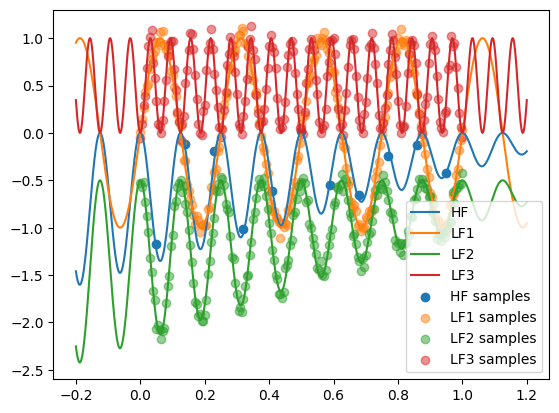

In [2]:
func = MengCase1(noise_std=0.0)
# generate samples (21 HF samples, 201 LF samples)
lf_samples = torch.linspace(0, 1, 201).reshape(-1, 1)
hf_samples = torch.linspace(0.05, 0.95, 11).reshape(-1, 1)
# add the end points

# training configure
samples = [hf_samples, lf_samples]

# generate responses
lf1_responses = func.lf1(lf_samples, noise_lf=0.05)
lf2_responses = func.lf2(lf_samples, noise_lf=0.05)
lf3_responses = func.lf3(lf_samples, noise_lf=0.05)
# get the high-fidelity responses
hf_responses = func.hf(hf_samples, noise_hf=0.05)
# generate the test points
test_samples = torch.linspace(-0.2, 1.2, 1001).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = func.hf(test_samples, noise_hf=0.0)
test_lf1_responses_noiseless = func.lf1(test_samples, noise_lf=0.0)
test_lf2_responses_noiseless = func.lf2(test_samples, noise_lf=0.0)
test_lf3_responses_noiseless = func.lf3(test_samples, noise_lf=0.0)
# noise responses
test_hf_responses = func.hf(test_samples, noise_hf=0.05)

# dataset of lf1 and hf
responses_lf1 = [hf_responses, lf1_responses]
# dataset of lf2 and hf
responses_lf2 = [hf_responses, lf2_responses]
# dataset of lf2 and hf
responses_lf3 = [hf_responses, lf3_responses]

# plot the function
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, test_lf1_responses_noiseless,   label="LF1")
ax.plot(test_samples, test_lf2_responses_noiseless,  label="LF2")
ax.plot(test_samples, test_lf3_responses_noiseless,  label="LF3")

# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf1_responses, alpha=0.5, label="LF1 samples")
ax.scatter(lf_samples, lf2_responses, alpha=0.5,  label="LF2 samples")
ax.scatter(lf_samples, lf3_responses, alpha=0.5, label="LF3 samples")

plt.legend()

plt.show()

## Configurations for DNN and BNN


In [3]:
# create the configuration of the low-fidelity model
lf_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "optimizer": "Adam",
    "lr": 0.001,
    "weight_decay": 0.000001,
    "loss": "mse",
}
# create the configuration of the high-fidelity model
hf_configure = {
    "in_features": 1,
    "hidden_features": [500, 500],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}

# lf train config
lf_train_config = {
    "batch_size": None,
    "num_epochs": 5000,
    "print_iter": 100,
    "data_split": True,
}
# hf train config
hf_train_config = {
    "num_epochs": 2000,
    "sample_freq": 100,
    "print_info": True,
    "burn_in_epochs": 1000,
}

## Initiate the model and train the model

In [4]:
# create the DNN-LR-BNN model
model = DNNLinearRegressionBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_configure,
    beta_optimize=True,
    lf_order=1, # the order of the low-fidelity model, it supports 1, 2, and 3
    beta_bounds=[-1, 1],
    optimizer_restart=20,
    discrepancy_normalization="diff", # normalization of the discrepancy (Bayesian residual)
)

In [5]:
# train the model
model.train(
    X=samples,
    Y=responses_lf2,  # the responses of the low-fidelity and high-fidelity models, respones_lf1, responses_lf2, responses_lf3
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

epoch:  100 train loss:  0.9003111124038696 test loss:  0.6933962106704712
epoch:  200 train loss:  0.8989272117614746 test loss:  0.697627604007721
epoch:  300 train loss:  0.8975346684455872 test loss:  0.7028972506523132
epoch:  400 train loss:  0.8962906002998352 test loss:  0.7104636430740356
epoch:  500 train loss:  0.8956401944160461 test loss:  0.7171752452850342
epoch:  600 train loss:  0.8951247930526733 test loss:  0.7185314297676086
epoch:  700 train loss:  0.8944339752197266 test loss:  0.7203068733215332
epoch:  800 train loss:  0.8934503793716431 test loss:  0.7216446399688721
epoch:  900 train loss:  0.891497790813446 test loss:  0.722510576248169
epoch:  1000 train loss:  0.8862317800521851 test loss:  0.7203560471534729
epoch:  1100 train loss:  0.8727854490280151 test loss:  0.7127379775047302
epoch:  1200 train loss:  0.839390754699707 test loss:  0.700400710105896
epoch:  1300 train loss:  0.7975592613220215 test loss:  0.6924536228179932
epoch:  1400 train loss:  

/home/yaga/Documents/GitHub/mfbml/src/mfbml/inference/psgld.py:108: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1642.)
  V.mul_(alpha).addcmul_(1 - alpha, d_p, d_p)


epoch:     0/ 2000
nll_loss: 20.120, prior_loss: 231834.203, total: 231854.328
noise: 0.5578772208748205
epoch:   100/ 2000
nll_loss: 79.444, prior_loss: 292285.656, total: 292365.094
noise: 0.5578772208748205
epoch:   200/ 2000
nll_loss: 20.575, prior_loss: 307070.625, total: 307091.188
noise: 0.5578772208748205
epoch:   300/ 2000
nll_loss: 28.447, prior_loss: 318874.281, total: 318902.719
noise: 0.5578772208748205
epoch:   400/ 2000
nll_loss: 12.690, prior_loss: 329093.531, total: 329106.219
noise: 0.5578772208748205
epoch:   500/ 2000
nll_loss: 17.569, prior_loss: 337941.469, total: 337959.031
noise: 0.5578772208748205
epoch:   600/ 2000
nll_loss: 14.904, prior_loss: 345809.906, total: 345824.812
noise: 0.5578772208748205
epoch:   700/ 2000
nll_loss: 21.832, prior_loss: 352641.094, total: 352662.938
noise: 0.5578772208748205
epoch:   800/ 2000
nll_loss: 11.869, prior_loss: 358854.688, total: 358866.562
noise: 0.5578772208748205
epoch:   900/ 2000
nll_loss: 16.959, prior_loss: 364413

In [6]:
# print the coefficients of the linear transfer-learning model 
print(model.beta) 

[0.36134252 0.77248949]


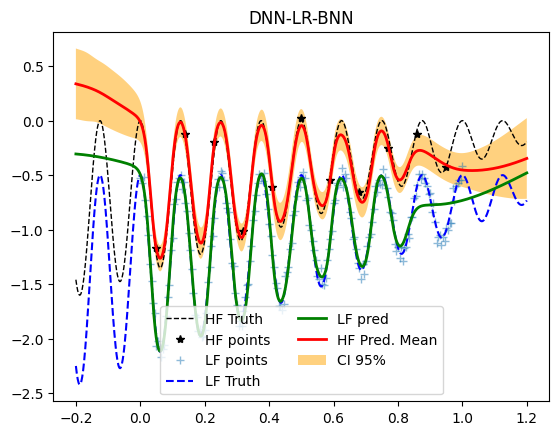

In [7]:
# visualize the posterior of the developed dnn-lr-bnn model
pred_hy,  pred_epistemic, pred_total_unc, pred_aleatoric = model.predict(X=test_samples)
# get lf predictions
pred_lf1_y = model.predict_lf(X=test_samples, output_format="numpy")

# plot
fig, ax = plt.subplots()
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
        'k--',
    linewidth=1,
    label="HF Truth",
)

ax.plot(hf_samples, hf_responses, "k*", label="HF points")
# plot lf samples
ax.plot(lf_samples, lf2_responses, '+',  label="LF points", alpha=0.5)
# plot the true lf1
ax.plot(test_samples.numpy(), test_lf2_responses_noiseless.numpy(), 'b--', label="LF Truth")
ax.plot(test_samples.numpy(), pred_lf1_y,
        'g-', linewidth=2, label="LF pred")
ax.plot(test_samples.numpy(), pred_hy, 'r-', linewidth=2, label="HF Pred. Mean")

ax.fill_between(
    test_samples.flatten().numpy(),
    (pred_hy - 1.96 * pred_total_unc).reshape(-1),
    (pred_hy + 1.96 * pred_total_unc).reshape(-1),
    alpha=0.5,
    label="CI 95%",
    color="orange", 
    edgecolor=None,
)
plt.legend(loc="lower center", ncol=2)
plt.title("DNN-LR-BNN") 
plt.show()

# have fun!